# Fine-tune SAM (Segment Anything Model) on a Custom Image Dataset in Amazon SageMaker

In this notebook you will learn how to fine-tune Meta's Segment Anything Model (SAM) for binary semantic segmentation on your custom image dataset. Scripts have been optimized for use with SageMaker Training Jobs (using the `PyTorch()` estimator class) and the PyTorch distributed data parallel (DDP) wrapper.

It is recommended to run this notebook on a `ml.g5.2xlarge` instance using the latest SageMaker Distribution as the Image. The training job can be run on a `ml.g5.12xlarge` or larger.

# 1. Intro & Setup

#### Why fine-tune a pre-trained vision foundation model?

Vision Transformer (ViT)-based foundation models (FMs) are large, general-purpose computer vision models that have been pre-trained on vast amounts of image data in a porcess called [self-supervised learning](https://en.wikipedia.org/wiki/Self-supervised_learning). During the training process, input images are divided into equally sized patches and a certain portion of patches is masked (i.e., withheld) from the model. The core training objective is for the ViT to fill in the missing patches, effectively re-creating the original image. Note that this process does not typically required labelled data.

The key component of interest resulting from this pre-training process is the Vision Encoder which has learned to produce embeddings that represent any given input image in lower dimensional space without significant loss of information. Fine-tuning leverages this capability by training (or adapting) a specialized decoder that sits on top of the pre-trained ViT and takes the embeddings generated by the encoder as input. This has several advantages, compared to training a dedicated model from scratch. First, the process usually requires less labeled data. Second, the decoder is typically lightweight and can often be trained on a single GPU. Third, the new model takes advantage of the representation capabilities of the pre-trained image encoder, re-using it for multiple downstream tasks.

#### SAM architecture and how to fine-tune.
The Segment Anayting Model (SAM) is made up of 3 main modules:
* The VisionEncoder: a VIT based image encoder. It computes the image embeddings using attention on patches of the image. Relative Positional Embedding is used. SAM leverages a pre-trained vision encoder trained using masked auto-encoding (MAE).
* The PromptEncoder: generates embeddings for points, bounding boxes, and/or text prompts. Here we will use only bounding boxes as prompts.
* The MaskDecoder: a two-ways transformer which performs cross attention between the image embedding and the prompt embeddings (->) and between the prompt embeddings and the image embeddings.

Fine-tuning focuses on the __MaskDecoder__. All other weights are frozen.

<p>
	<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/sam-architecture.png" alt="Model architecture">
	<em> Detailed architecture of Segment Anything Model (SAM).</em>
</p>

There is also a fourth component (sometimes called the neck), which is represented as a convolutional layer taking a segmentation mask as input. This component can be optionally used to submit a previously generated mask as context whenever users interact with SAM over multiple iterations (e.g., re-drawing bounding boxes, etc.). We will not use this option here. 

#### Retrieving SAM weights from the HuggingFace (HF) Hub.

The SAM foundation model is available as an open-source implementation under the [Apache 2.0 license](https://choosealicense.com/licenses/apache-2.0/) via the HuggingFace Hub. There are three different versions of SAM available:
* [`sam-vit-base`](https://huggingface.co/facebook/sam-vit-base) (~94M params, 0.3 GB)
* [`sam-vit-large`](https://huggingface.co/facebook/sam-vit-large) (~312M params, 1.25 GB)
* [`sam-vit-huge`](https://huggingface.co/facebook/sam-vit-huge) (~641M params, 2.56 GB)

For illustrative purposes, this example focuses on fine-tuning `sam-vit-large`, although the model type is a parameter that is configurable and you can opt for the smaller (or larger) versions depending on your preferences.

#### Training on Amazon SageMaker.
Training is fascilitated via a [SageMaker Training Job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html) and is implemented on top of a managed [PyTorch Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#train-a-model-with-pytorch) that leverages AWS-managed pre-built training Docker image optimized for PyTorch environments.

### 1.1 Initialize Development Environment

To get things started we will initialize SageMaker session and environment variables and install any missing dependencies needed in this notebook. This notebook works best on an `ml.g5.2xlarge` instance.

In [1]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import boto3

sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
s3_prefix = "geosam"

role = (
    get_execution_role()
)  # provide a pre-existing role ARN as an alternative to creating a new role
print(f"SageMaker Execution Role:{role}")

client = boto3.client("sts")
account = client.get_caller_identity()["Account"]
print(f"AWS account:{account}")

session = boto3.session.Session()
region = session.region_name
print(f"AWS region:{region}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
SageMaker Execution Role:arn:aws:iam::030281537295:role/service-role/AmazonSageMaker-ExecutionRole-20240112T112257
AWS account:030281537295
AWS region:us-west-2


In [2]:
!pip install -q patchify
!micromamba install -q gdal==3.6.4 --yes --channel conda-forge --name base

In [3]:
import os, time, json, random
import matplotlib.pyplot as plt
import numpy as np
import random
from random import sample 
from random import shuffle 
import skimage
import warnings
warnings.filterwarnings('ignore')

# 2. Load Raw Satellite Imagery
SAM was trained on >1bn annotated images (SA-1B Dataset). You can explore the SA-1B Dataset [here](https://segment-anything.com/dataset/index.html). To illustrate the power of fine-tuning we will focus on the case of satellite image segmentation, a class of images that is not represented widely in SA-1B. Specialized image data like satellite imagery represents a good out-of-domain test case to demonstrate the power of fine-tuning a general-purpose vision foundation model like SAM for highly specialized applications and domains.

This tutorial uses [SpaceNet data](https://registry.opendata.aws/spacenet/), available on the Amazon Registry of Open Data. This dataset consists of 200m x 200m satellite images/labels. Specifically, we focus on the [SpaceNet 2: Building Detection v2](https://spacenet.ai/spacenet-buildings-dataset-v2/) dataset which is provided by SpaceNet Partners and available under a [Creative Commons BY-SA 4.0 DEED](https://creativecommons.org/licenses/by-sa/4.0/) license.

We use pre-extracted ~0.3m resolution pan-sharpened RGB (`PS-RGB`) 3-channel satellite images from the city of Las Vegas that have been white-balanced. We also use pre-extracted ground truth masks of buildings as GeoJSON files (`geojson_buildings/` directory). This pre-processed data sample is hosted on a public Amazon S3 bucket: `s3://aws-satellite-lidar-tutorial/data/` and can be explored [here](https://aws-satellite-lidar-tutorial.s3.amazonaws.com/index.html#data/buildings/).

The below code downloads the dataset to the local drive so we can process it further and get it ready for training. For illustrative purposes, we limit the number of downloaded images by setting the `max_items=` variable.

In [4]:
def download_files_from_s3(bucket_name, prefix, local_dir,max_items=None, img_ids=None,verbose=False):
    """
    Download files from an Amazon S3 bucket to local directory.
    """
    s3 = boto3.client('s3')
    #create the local directory if it doesn't exist
    os.makedirs(local_dir, exist_ok=True)
    #get lits of all objects in bucket
    continuation_token = None
    objects = []
    i=0
    while True:
        # Retrieve a batch of object keys
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        # Append the object keys to the list
        for obj in response.get('Contents', []):
            objects.append(obj['Key'])
        # Check if there are more objects to retrieve
        if response.get('IsTruncated'):
            continuation_token = response.get('NextContinuationToken')
        else:
            break
    print(f"{len(objects)} found in directory...")

    #optionally sample from contents
    def subset_objects(objects, img_ids):
        def contains_substring(s):
            return any(substr in s for substr in img_ids)
        return list(filter(contains_substring, objects))
    if img_ids and max_items: 
        raise Exception("You can either submit a list of img IDs to be downloaded, or set a max number of items to download, not both")
    if img_ids:
        print("select images based on provided list")
        objects = subset_objects(objects=objects, img_ids=img_ids)
    elif max_items:
        print("randomly select images")
        img_ids = [x.split("_")[-1].split(".")[0] for x in objects]
        img_ids = [x+"." for x in img_ids] #need to add . as stop word
        random.seed(42) #fix seed
        img_ids = random.sample(img_ids,max_items)
        objects = subset_objects(objects=objects, img_ids=img_ids)
    print(f"{len(objects)} imgs to be downloaded...")

    #download objects to the local directory
    for obj in objects:
        local_path = os.path.join(local_dir, os.path.relpath(obj, prefix))
        # Create the local directory if it doesn't exist
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        try:
            s3.download_file(bucket_name, obj, local_path)
            if verbose:
                print(f"Downloaded: {obj} to {local_path}")
        except Exception as e:
            print(f"Error downloading {obj}: {e}")
        if (i+1)%250==0:
            print(f"{i+1} objects downloaded")
        i+=1
    
    return img_ids

Let's download the data to the local drive. This wil take a few minutes to complete.

In [6]:
# Specify the S3 bucket name, prefix, and local directory
bucket_name = 'aws-satellite-lidar-tutorial'
local_dir = './data/'
# Call the function to download files
img_ids=download_files_from_s3(bucket_name=bucket_name, prefix='data/buildings/RGB+ELEV/', local_dir=local_dir+"RGB+ELEV/",img_ids=None,max_items=500)
img_ids=download_files_from_s3(bucket_name=bucket_name, prefix='data/buildings/geojson_buildings/', local_dir=local_dir+"geojson_buildings/",img_ids=img_ids, max_items=None)

3084 found in directory...
randomly select images
500 imgs to be downloaded...
250 objects downloaded
500 objects downloaded
3850 found in directory...
select images based on provided list
500 imgs to be downloaded...
250 objects downloaded
500 objects downloaded


# 3. Prepare Train, Validation and Test Datasets

We'll need to take the following steps to set everything up for training:

1. Create masks: The SpaceNet images come with GeoJSON annotations as polygon vectors. These cannot be directly accepted by SAM; instead, we will convert them to binary mask images. These masks will be the "ground truth labels".
2. Seperate out training, validation and test sets
3. Patchify images: SpaceNet images come in 200mx200m which breaks down to 650x650 pixels, we will use patchify to create 256x256 patches of the satellite images.
4. Create HF `Dataset()` objects and upload to S3 for easy data loading during training
5. Create a routine for bounding box prompt generation (will be integrated into the dataloader in the training script)

### 3.1 Create Masks

In [15]:
img_dir = 'data/RGB+ELEV/'
bldg_dir = 'data/geojson_buildings/'
prefix = 'SN2_buildings_train_AOI_2_Vegas_'
samples = [f.split("_")[-1].split(".")[0] for f in os.listdir(img_dir)]

In [16]:
#!/usr/bin/env python2
from osgeo import gdal, ogr
###############################################################################
def create_building_mask(rasterSrc, vectorSrc, npDistFileName='',
                         noDataValue=0, burn_values=1):
    '''
    Create building mask for rasterSrc,
    Similar to labeltools/createNPPixArray() in spacenet utilities
    '''
    ## open source vector file that truth data
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

    ## extract data from src Raster File to be emulated
    ## open raster file that is to be emulated
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize

    ## create First raster memory layer, units are pixels
    # Change output to geotiff instead of memory 
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(npDistFileName, cols, rows, 1, gdal.GDT_Byte, 
                           options=['COMPRESS=LZW'])
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(noDataValue)    
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
    dst_ds = 0
    
    return 

Generate masks for all samples.

In [17]:
i=0
failed_samples=[]
for s in samples:
    try:
        img_path = img_dir+prefix + 'RGB+ELEV_' + s + '.tif'
        bldg_path = bldg_dir+prefix+'geojson_buildings_'+ s +'.geojson'
        mask_path=bldg_dir + prefix + 'geojson_buildings_mask_' + s + '.tif'
        create_building_mask(rasterSrc=img_path, vectorSrc=bldg_path, npDistFileName=mask_path)
    except:
        #print(f"sample {s} failed to load...")
        failed_samples.append(s)
        
    if (i+1)%500==0:
        print (f"{(i+1)} samples processed...")
    i+=1

500 samples processed...


Let's review the results.

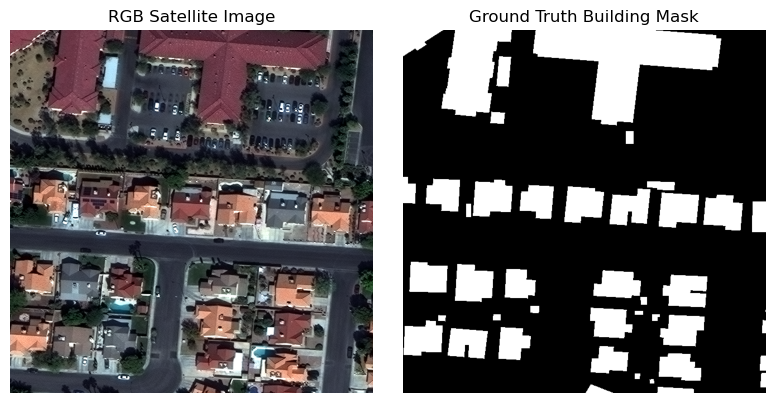

In [88]:
#retrieve random sample
sample = samples[random.randint(0,len(samples)-1)]
img_path = img_dir+prefix + 'RGB+ELEV_' + sample + '.tif'
mask_path=bldg_dir + prefix + 'geojson_buildings_mask_' + sample + '.tif'
rgb = skimage.io.imread(img_path)[..., :3]
mask = skimage.io.imread(mask_path)
#plot
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].imshow(rgb)
ax[0].set_title("RGB Satellite Image",fontsize=12)
ax[1].imshow(np.array(mask)*255,cmap='gray')
ax[1].set_title("Ground Truth Building Mask",fontsize=12)
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
os.makedirs('./assets',exist_ok=True)
plt.savefig('./assets/raw_data.png')
plt.show()

### 3.2. Define Train, Validation and Test Sample IDs

In [19]:
def split_data(sample_list,splits=[70,20,10],limit=None):
    if limit:  
        sample_list = sample(sample_list,limit)
    shuffle(sample_list)
    count=len(sample_list)
    train_sample=sample_list[0:int(count*splits[0]/100)]
    validation_sample=sample_list[int(count*splits[0]/100):int(count*(splits[0]+splits[1])/100)]
    test_sample=sample_list[int(count*(splits[0]+splits[1])/100):]

    return train_sample,validation_sample,test_sample

In [20]:
train_sample, validation_sample, test_sample = split_data(sample_list=samples,
                                                          splits=[70,10,20]) #limit to 1k images

### 3.3 Patchify Images

Next we'll create smaller images that work better as input images for SAM and impose less of an overhead during data loading. We'll be creating overlapping patches of 256x256 pixels from each larger image.

In [22]:
#Desired patch size for smaller images and step size.
width = 650 #the width of the image
patch_size = 256
step = 256
overlap = (3*patch_size-width)/2
step=int(patch_size-overlap)

In [23]:
from patchify import patchify
def patchify_images(sample_ids,patch_size,step,img_dir,prefix):
    all_img_patches = []
    all_mask_patches = []
    
    for s in sample_ids:
        
        img_path = img_dir+prefix + 'RGB+ELEV_' + s + '.tif'
        mask_path=bldg_dir + prefix + 'geojson_buildings_mask_' + s + '.tif'
        
        rgb = skimage.io.imread(img_path)[..., :3]
        mask = skimage.io.imread(mask_path)
    
        #images
        patches_img = patchify(rgb, (patch_size, patch_size,3), step=step)
        img_patches = []
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:,:]
                single_patch_img = single_patch_img.reshape((patch_size, patch_size, 3))
                single_patch_img = single_patch_img.astype(np.uint8)
                all_img_patches.append(single_patch_img)
        #masks
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        mask_patches = []
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i,j,:,:]
                all_mask_patches.append(single_patch_mask)
    
    images = np.array(all_img_patches)
    masks = np.array(all_mask_patches)

    # Create a list to store the indices of non-empty masks
    valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
    # Filter the image and mask arrays to keep only the non-empty pairs
    filtered_images = images[valid_indices]
    filtered_masks = masks[valid_indices]
    print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
    print("Mask shape:", filtered_masks.shape)

    return filtered_images,filtered_masks

In [24]:
images_train,masks_train = patchify_images(sample_ids=train_sample,patch_size=patch_size,step=step,img_dir=img_dir,prefix=prefix)
images_validation,masks_validation = patchify_images(sample_ids=validation_sample,patch_size=patch_size,step=step,img_dir=img_dir,prefix=prefix)
images_test,masks_test = patchify_images(sample_ids=test_sample,patch_size=patch_size,step=step,img_dir=img_dir,prefix=prefix)

Image shape: (2629, 256, 256, 3)
Mask shape: (2629, 256, 256)
Image shape: (376, 256, 256, 3)
Mask shape: (376, 256, 256)
Image shape: (760, 256, 256, 3)
Mask shape: (760, 256, 256)


### 3.4 Create HuggingFace Dataset Objects

We will now create a HF Dataset object from this dictionary and upload it to S3 where it can be used by the TrainigJob. Note: depending on your instance, this will take several minutes. You may also have to opt for an instance with larger memory depending on how much data you have selected to be used in training (set the `limit=` parameter in the `split_data()` routine accordingly).

In [25]:
from datasets import Dataset, Image
def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,"label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [26]:
images = [img.astype(np.uint8) for img in images_train]
labels = [mask.astype(np.uint8) for mask in masks_train]
train_dataset = create_dataset(images, labels)
train_dataset.save_to_disk("./data/train_dataset")
del train_dataset

Saving the dataset (0/3 shards):   0%|          | 0/2629 [00:00<?, ? examples/s]

In [27]:
images = [img.astype(np.uint8) for img in images_validation]
labels = [mask.astype(np.uint8) for mask in masks_validation]
val_dataset = create_dataset(images, labels)
val_dataset.save_to_disk("./data/valid_dataset")
del val_dataset

Saving the dataset (0/1 shards):   0%|          | 0/376 [00:00<?, ? examples/s]

In [28]:
images = [img.astype(np.uint8) for img in images_test]
labels = [mask.astype(np.uint8) for mask in masks_test]
test_dataset = create_dataset(images, labels)
test_dataset.save_to_disk("./data/test_dataset")
del test_dataset

Saving the dataset (0/1 shards):   0%|          | 0/760 [00:00<?, ? examples/s]

Let's upload the data to S3 so that it can be used in the Training Job.

> Note: If you are using an S3 bucket other than the SageMaker default bucket to save data make sure you have [server-side encryption](https://docs.aws.amazon.com/AmazonS3/latest/userguide/serv-side-encryption.html) enabled (e.g., SSE-S3) and encryption in transit enforced (by using the [aws:SecureTransport](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference_policies_elements_condition_operators.html#Conditions_Boolean) condition in the bucket policy). Also see the [S3 Security Best Practices](https://docs.aws.amazon.com/AmazonS3/latest/userguide/security-best-practices.html) for more details.

In [29]:
from botocore.exceptions import ClientError
def upload_folder_to_s3(local_folder, bucket_name, s3_prefix=None):
    s3_client = boto3.client('s3')
    s3_resource = boto3.resource('s3')

    # Delete all existing content in the specified S3 prefix
    if s3_prefix:
        bucket = s3_resource.Bucket(bucket_name)
        bucket_objects = bucket.objects.filter(Prefix=s3_prefix)
        for obj in bucket_objects:
            s3_client.delete_object(Bucket=bucket_name, Key=obj.key)
            #print(f"Deleted existing object s3://{bucket_name}/{obj.key}")

    # Walk the local folder
    for root, dirs, files in os.walk(local_folder):
        for file in files:
            local_file_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_file_path, local_folder)
            if s3_prefix:
                s3_file_path = os.path.join(s3_prefix, relative_path)
            else:
                s3_file_path = relative_path
            try:
                #print(f"Uploading {local_file_path} to s3://{bucket_name}/{s3_file_path}")
                s3_client.upload_file(local_file_path, bucket_name, s3_file_path)
            except ClientError as e:
                print(f"Error uploading {local_file_path}: {e}")

In [30]:
upload_folder_to_s3(local_folder="./data/train_dataset", bucket_name=default_bucket, s3_prefix=f"{s3_prefix}/train")
upload_folder_to_s3(local_folder="./data/valid_dataset", bucket_name=default_bucket, s3_prefix=f"{s3_prefix}/valid")
upload_folder_to_s3(local_folder="./data/test_dataset", bucket_name=default_bucket, s3_prefix=f"{s3_prefix}/test")

Let's verify that the datasets can be loaded...

In [31]:
from datasets import load_from_disk
test_dataset = load_from_disk("./data/test_dataset")

In [32]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 760
})

And that the data is intact...

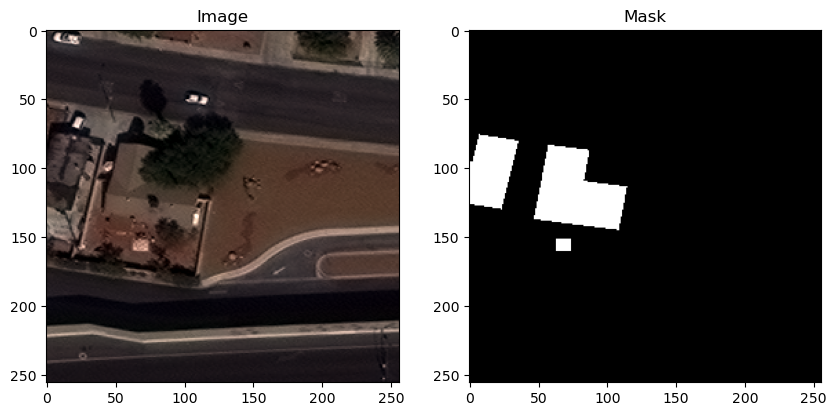

In [38]:
img_num = random.randint(0, len(test_dataset)-1)
example_image = test_dataset[img_num]["image"]
example_mask = test_dataset[img_num]["label"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot the image
axes[0].imshow(np.array(example_image))
axes[0].set_title("Image")

# plot the maks
axes[1].imshow(np.array(example_mask)*255, cmap='gray')
axes[1].set_title("Mask")

# Display the images side by side
plt.show()

### 3.5 Generate Bounding Box Promts

Since SAM requires a prompt in addition to the raw image as input, we will generate it next. Prompts can be bounding boxes, points, and even text. Here we will use a bounding box that indicates an approximate area of interest within the image, where SAM should produce a segmentation. The function below generates a bounding box with some degree of positional randomization for a given polygon in an image.

In [55]:
def get_bounding_box(ground_truth_map):
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    return bbox

In [40]:
#helper function to show mask
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [41]:
import matplotlib.patches as patches
def show_bbox_prompt(bbox, ax):
    xy=(bbox[0],bbox[1])
    h=bbox[3]-bbox[1]
    w=bbox[2]-bbox[0]
    rect = patches.Rectangle(xy=xy,height=h, width=w,linewidth=1, facecolor='none',edgecolor="r")
    ax.add_patch(rect)

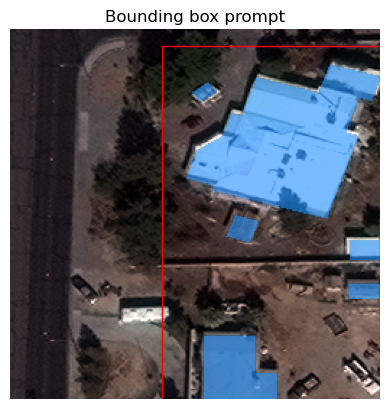

In [45]:
#sample image
img_num = random.randint(0, test_dataset.shape[0]-1)
image = test_dataset[img_num]["image"]
label = test_dataset[img_num]["label"]

fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(label)
bbox = get_bounding_box(np.array(ground_truth_seg))
show_mask(ground_truth_seg, axes)
show_bbox_prompt(bbox, axes)
axes.title.set_text(f"Bounding box prompt")
axes.axis("off")
plt.show()

# 4. Run the Sagemaker Training Job

#### PyTorch Estimator
In order to create our sagemaker training job we will use a `PyTorch` Estimator. The Estimator handles all end-to-end Amazon SageMaker training and deployment tasks. In the Estimator we define, which fine-tuning script (`entry_point`) be used, where this script is located (`source_dir`), which `instance_type` should be used, and which `hyperparameters` are passed, among other things. We can also pass a `requirements.txt` file (this should be located in the same folder as the training script). This is useful in case you require custom libraries:

```python
estimator = PyTorch(entry_point='train.py',
                    source_dir='./scripts',
                    base_job_name='<job-name>',
                    instance_type='ml.p3.2xlarge',
                    instance_count=1,
                    py_version='py310',
                    framework_version='2.2',
                    role=role,
                    distribution = {"pytorchddp": {"enabled": True}}
                    hyperparameters = {'epochs': 1,
                                       'train_batch_size': 32,
                                       'model_id':'facebook/sam-vit-base',
                                      }
                    use_spot_instances= True,
                    max_run=  60 * 60 * 24,
                    max_wait= 60 * 60 * 24
                    )
```

When we create a SageMaker training job, SageMaker takes care of starting and managing the required ec2 instances for us, providing the fine-tuning script `train.py` and downloading the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`.

Sagemaker is also providing useful properties about the training environment through various environment variables, including the following:
* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.
* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the PyTorch estimator’s fit call, named `train` and `valid`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_VALID` are set.

#### Distributed Training on SageMaker

`facebook/sam-vit-large` is a moderately large model which can fit a single modern GPU's vRAM, provided batch size is not too large. Yet, to speed up training times, especially when training on large datasets, distributing the training load across multiple GPUs may be advisable. In this example we have implemented a Data Parallel strategy using PyTorch's Distributed Data Parallel framework. Adapting a PyTorch training script for DDP is straight forward and detailed [here]().

In addition to distributed training, we have made the following optimizations:

* **Gradient Accumulation**: Gradient Accumulation helps reduce the memory footprint by achieving the same effective batch size at significantly smaller actual batch sizes. In others words: with a gradient accumulation frequency of 2, you can reduce batch size by a factor of 2 for the same result, hence reducing memory footprint associated with 1/ storing large batches on GPU and 2/ persisting the activations associated with passing larger batches through the network. Note that this can come at a small speed penalty due to more forward and backward passes through the network.
* **Mixed Precision Training (Pytorch AMP)**: Mixed precision training reduces compute and usually memory requirements. It does so by representing some matrices in lower precision (i.e., FP16 at 2 bytes/element, vs. FP32 full precision at 4 bytes/element). The memory savings exclusively originate from reducing the activation footprint. Weights are saved in both full and half precision, optimizer states retain full precision and gradients are re-cast to full precision for the optimization. Mixed Precision will be most effective if the share of activations in the total memory footprint is large (as is the case with large minibatch sizes).

To further reduce memory footprint you may also consider [Gradient Checkpointing](https://github.com/prigoyal/pytorch_memonger/blob/master/tutorial/Checkpointing_for_PyTorch_models.ipynb), which essentially trades memory for compute. Also refer to [this](https://huggingface.co/docs/transformers/v4.20.1/en/perf_train_gpu_one) post for additional details. To improve cost performance we have also enabled spot training by setting `use_spot_instances= True` and configuring `max_run` and `max_wait`.

Let's have a look at the script.

In [72]:
!pygmentize ./src/train_distributed.py

### 4.1 Parameterize the Estimator

First, let us define some hyperparameters:

In [39]:
# hyperparameters, which are passed into the training job
hyperparameters={'num_epochs': 35, #how many full passes over training set
                 'train_batch_size': 4, #size of the minibatch, significantly impacts vRAM requirements! use gradient accumulation to achieve higher effective batch sizes!
                 'gradient_accum_freq': 8, #integer value indicating once in how many minibatches we would like to update the network weights
                 'learning_rate': 1e-5, # learning rate
                 'model_id':'facebook/sam-vit-large' # th HF model ID, you can switch between [facebook/sam-vit-base, facebook/sam-vit-large, facebook/sam-vit-huge]
                }

In our `train_distributed.py`, we use print statements to emit metrics from our training such as training loss or throughput. During training, this information is printed to std.out. In order for SageMaker to successfully parse our metrics and make them observable in  Amazon CloudWatch (CW) we must provide the Regular Expressions (REGEX), that instruct SageMaker how to extract the numerical values from our print statement above, as described in the documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html). We do this with our metric_definitions object below, which we then pass as a parameter to our estimator.

In [46]:
metric_definitions = [{'Name': 'training-loss', 'Regex': 'training loss: (.*?);'},
                      {'Name': 'validation-loss', 'Regex': 'validation loss: (.*?);'},
                      {'Name': 'epoch-duration-sec', 'Regex': 'duration: (.*?);'},
                      {'Name': 'throughput-samples-per-sec', 'Regex': 'throughput: (.*?);'}
                     ] 

We also need to define the infrastructure we want to train on. Given, that we have not implemented distributed training in this example, we pick a single-GPU instance. Refer to the [EC2 website](https://aws.amazon.com/ec2/instance-types/?nc1=h_ls) for an overview of available instance types and their specifications.

In [47]:
instance_type_multi_gpu= 'ml.g5.12xlarge' #4GPUs

We now have everything we need to parameterize the estimator:

In [48]:
# define Training Job Name 
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig
from sagemaker.pytorch.estimator import PyTorch
model_name_short=str(hyperparameters['model_id'].split('/')[-1])
job_name = f'fine-tune-distributed-{model_name_short}-SpaceNet-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'
distribution = {"pytorchddp": {"enabled": True}}
estimator_distributed = PyTorch(entry_point='train_distributed.py',
                                source_dir='./src',
                                metric_definitions = metric_definitions,
                                instance_type=instance_type_multi_gpu,
                                instance_count=1, 
                                base_job_name=job_name,
                                role=role,
                                py_version = "py310", #python version
                                framework_version = "2.1.0", #torch version
                                hyperparameters = hyperparameters,
                                distribution=distribution,
                                use_spot_instances= True, #use spot training
                                max_run=  60 * 60 * 24, #max run time
                                max_wait= 60 * 60 * 24, #max wait for instance to become available
                               )

### 4.2 Start SageMaker TrainingJob

Finally, let's kick-off the training job by calling `estimator.fit()`

In [46]:
data = {
    'train': f's3://{default_bucket}/{s3_prefix}/train',
    'valid': f's3://{default_bucket}/{s3_prefix}/valid'
}
# starting the train job with our uploaded datasets as input
estimator_distributed.fit(data, logs="Training", wait=True)

While it is running you can monitor instance metrics (GPU utilization, GPU vRAM load, etc.) via Amazon CloudWatch. Given that we have defined custom metrics above these will now also appear in CW. Once the training job has completed successfully, the model artifact will be saved to S3. We can verify the location below by calling `estimator.model_data`.

In [48]:
print(f"Model path: {estimator_distributed.model_data}")

# 5. Run Batch Inference using the Fine-tuned SAM Model

Once training has completed, we can look at the model data and run inferences. Unless otherwise specified, model artifacts will be saved to the default sagemaker bucket: `s3://<sagemaker-default-bucket>/<job_name>/output/model.tar.gz`. As shown above the path can be retrieved by calling `estimator.model_data`.

Below we have implemented a routine for batch inference on the whole test set. For illustrative purposes, the inference routine is run locally, i.e., on the notebook instance itself. An alternative would be to specify a a [SageMaker Batch Tranfor Job for PyTorch Batch Inference](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_batch_transform/pytorch_mnist_batch_transform/pytorch-mnist-batch-transform.html). The code below can largely be re-used for this.

### 5.1 Download Fine-Tune Model Weights

Let's download the `model.tar.gz` model artifact and unzip the content. The resulting files contain the fine-tuned model weights (`model.safetensors`) and the model configuration (`config.json`).

In [49]:
model_path=estimator_distributed.model_data

In [50]:
import tarfile
import io
from urllib.parse import urlparse
from pathlib import Path
def unzip_targz_from_s3(s3_path, destination_folder):
    s3 = boto3.client('s3')
    # parse S3 path
    parsed_url = urlparse(s3_path)
    bucket_name = parsed_url.netloc
    object_key = parsed_url.path.lstrip('/')
    # download tar.gz from S3
    file_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
    tar_file_bytes = file_obj['Body'].read()
    # ppen tar.gz using BytesIO
    tar_file = tarfile.open(fileobj=io.BytesIO(tar_file_bytes), mode="r:gz")
    # create safe destination path
    safe_destination_folder = Path(destination_folder).resolve()
    # extract files to destination folder
    for member in tar_file.getmembers():
        # check if member file path is safe
        member_path = safe_destination_folder / member.name
        if str(member_path).startswith(str(safe_destination_folder)):
            tar_file.extract(member, path=safe_destination_folder)
    tar_file.close()

In [51]:
unzip_targz_from_s3(s3_path=model_path,
                   destination_folder="./model_artifact/")

### 5.2 Instantiate Model
We can use these weights and the model config to load a new `SamModel` class and use it for inference.

In [52]:
import torch
from transformers import SamModel
device = "cuda" if torch.cuda.is_available() else "cpu" #use GPU if available
fine_tuned_model = SamModel.from_pretrained(pretrained_model_name_or_path="./model_artifact/")
fine_tuned_model.to(device)

2024-05-02 22:10:28.788754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-23): 24 x SamVisionLayer(
        (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

### 5.3 Run Batch Inference

Now that we have a fine-tuned model initialized, we can run batch inference by instantiating a new dataloader for the test set and generating predictions using the previously instatiated SAM model object.

In [58]:
# LOAD DATA & INITIALIZE DATALOADER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import SamModel
from transformers import SamProcessor

class CustomSAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)
    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask
    return inputs

In [61]:
#instantiate processor, dataset and dataloader
data_test = load_from_disk("./data/test_dataset")
processor = SamProcessor.from_pretrained("facebook/sam-vit-large") #instantiate the processor associated with SAM
test_dataset = CustomSAMDataset(dataset=data_test, processor=processor) #instantiate dataset
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8,drop_last=True)

In [62]:
predictions=None
with torch.no_grad(): #disable grad calculation to save memory
    for item in test_dataloader:
        outputs = fine_tuned_model(pixel_values=item["pixel_values"].to(device),
                                   input_boxes=item["input_boxes"].to(device),
                                   multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)

        #apply sigmoid to get probabilities
        predicted_masks = torch.sigmoid(predicted_masks)

        #append predictions to single tensor
        if predictions is None:
            predictions = predicted_masks
        else:
            predictions = torch.cat((predictions, predicted_masks), dim=0)

Let's post-process the predictions to probability masks (soft and hard)

In [74]:
cutoff_p = 0.6
predictions_prob_mask = predictions.cpu().numpy().squeeze()
predictions_hard_mask = (predictions_prob_mask > cutoff_p).astype(np.uint8)

### 5.4 Review Predictions

In [116]:
#random idx
idx = random.randint(0,len(test_dataset)-1)

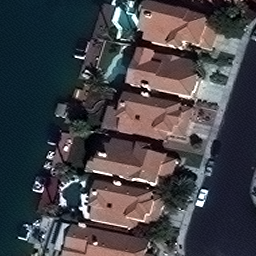

In [117]:
from PIL import Image
dataset=data_test #set dataset here
# load image
image = dataset[idx]["image"]
ground_truth_mask = np.array(dataset[idx]["label"])
image

Plot results

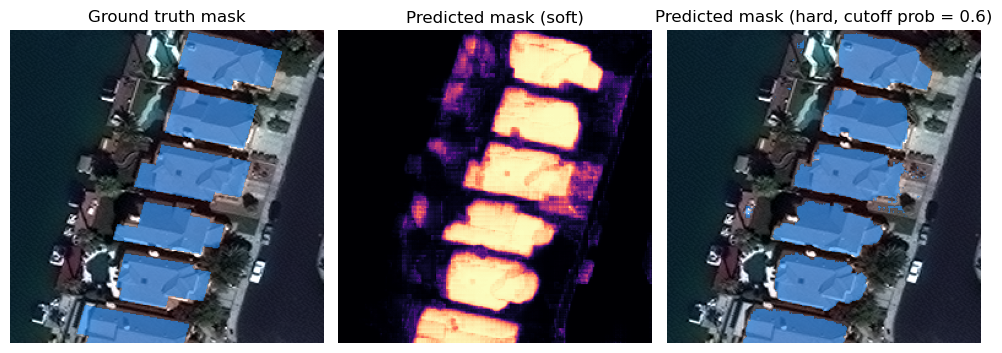

In [118]:
## import matplotlib.pyplot as plt
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(10,4), sharex=True, sharey=True)

axes[0].imshow(np.array(image))
show_mask(ground_truth_mask, axes[0])
axes[0].title.set_text("Ground truth mask")
axes[0].axis("off")

#axes[2].imshow(np.array(image))
axes[1].imshow(predictions_prob_mask[idx],"magma")
#show_mask(geosam_seg_prob, axes[1],random_color=True)
axes[1].title.set_text("Predicted mask (soft)")
axes[1].axis("off")

axes[2].imshow(np.array(image))
show_mask(predictions_hard_mask[idx], axes[2])
axes[2].title.set_text(f"Predicted mask (hard, cutoff prob = {cutoff_p})")
axes[2].axis("off")

plt.tight_layout()

os.makedirs('./assets',exist_ok=True)
plt.savefig('./assets/prediction_results.png')

# 6. Cleanup
To avoid incurring further costs after you have completed this notebook make sure to...
* delete any unwanted local files in this Jupyter Lab Space (i.e., the `data`, `model_artifact` directories)
* remove files persisted on S3 (i.e., `training`, `test` and `validation` datasets and the model `output` folder)
* stop the SageMaker JupyterLab Space this notebook is running on

---